In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

# Importing the data
dataset = pd.read_excel('/Users/mustafa/Documents/GitHub/ML_knife_QA/data/chiefs_knife_dataset.xlsx')
index_Ra = dataset.columns.get_loc('Ra')  # Index der Spalte für Rauheit

# Spezifikationsgrenzen
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215

# Einteilung in "gut" und "schlecht"
is_between_specification_bounds = (dataset['Ra'] >= LOWER_SPECIFICATION_LIMIT) & (dataset['Ra'] < UPPER_SPECIFICATION_LIMIT)
good_product_range = np.where(is_between_specification_bounds, "good", "bad")
dataset.insert(index_Ra + 1, 'Quality', good_product_range)

# Features und Zielvariable
X = dataset.loc[:, 'Original_Linienanzahl':'DFT_Median_sobel_Bereich'].values
y = dataset['Quality'].values


[[ 8.70000000e+01  1.19310345e+01  2.00870480e+01 ...  2.60000000e+01
   2.00000000e+00  2.40000000e+01]
 [ 7.70000000e+01  1.48831169e+01  2.29488273e+01 ...  2.60000000e+01
   4.00000000e+00  2.20000000e+01]
 [ 5.90000000e+01  1.96779661e+01  3.18382781e+01 ...  1.60000000e+01
   5.00000000e+00  1.10000000e+01]
 ...
 [ 9.93723333e-01  9.93468941e-01 -1.30763445e-02 ...  2.69993620e+01
   1.99309488e+00  2.50092318e+01]
 [ 1.00663969e+00  1.01341673e+00 -2.14581095e-03 ...  2.49954164e+01
   2.99579480e+00  2.20030958e+01]
 [ 9.94045386e-01  9.94401332e-01  1.31977327e-02 ...  2.79916869e+01
   4.99609517e+00  2.29972671e+01]]
['good' 'good' 'good' ... 'good' 'good' 'good']


Accuracy (Original Model - Validation): 0.7305433186490455
Classification Report (Original Model - Validation):
              precision    recall  f1-score   support

         bad       0.73      0.66      0.69       625
        good       0.73      0.79      0.76       737

    accuracy                           0.73      1362
   macro avg       0.73      0.73      0.73      1362
weighted avg       0.73      0.73      0.73      1362

Accuracy (Original Model): 0.7555816686251469
Classification Report (Original Model):
              precision    recall  f1-score   support

         bad       0.77      0.69      0.73       798
        good       0.75      0.82      0.78       904

    accuracy                           0.76      1702
   macro avg       0.76      0.75      0.75      1702
weighted avg       0.76      0.76      0.75      1702



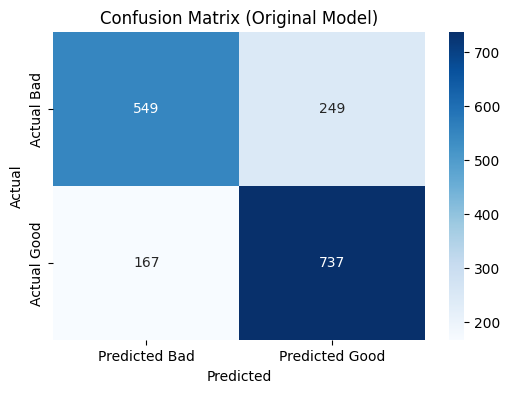

Beste Hyperparameter für Classifier: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best Model Accuracy: 0.7579318448883666
Best Model Classification Report:
              precision    recall  f1-score   support

         bad       0.77      0.69      0.73       798
        good       0.75      0.82      0.78       904

    accuracy                           0.76      1702
   macro avg       0.76      0.75      0.75      1702
weighted avg       0.76      0.76      0.76      1702



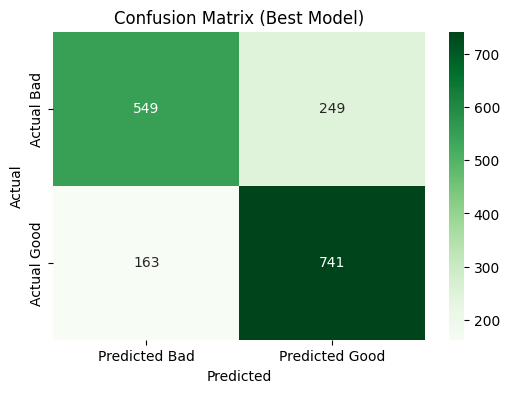

In [8]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Data Augmentation durch Rauschzugabe
noise = np.random.normal(0, 0.01, X_train.shape)  # Rauschen mit Mittelwert 0 und Standardabweichung 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels bleiben gleich

# Verknüpfung von Original- und Augmented Features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

# Feature-Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Modelltraining mit RandomForestClassifier (Vor Randomized Search)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred = classifier.predict(X_test_scaled)
y_val_pred = classifier.predict(X_val_scaled)

# Validation - Evaluierung
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)
print(f'Accuracy (Original Model - Validation): {accuracy_val}')
print(f'Classification Report (Original Model - Validation):\n{report_val}')

# Evaluierung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy (Original Model): {accuracy}')
print(f'Classification Report (Original Model):\n{report}')

# Confusion Matrix für das Originalmodell
cm_original = confusion_matrix(y_test, y_pred)

""" plt.figure(figsize=(6, 4))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Bad', 'Predicted Good'], yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Original Model)')
plt.show()
 """
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_original.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm_original.flatten()/np.sum(cm_original)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_original, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_original.png', dpi=300)

# Hyperparameter-Raster für Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Randomized Search für Random Forest Classifier
random_search_classifier = RandomizedSearchCV(estimator=classifier,
                                              param_distributions=param_grid, 
                                              n_iter=100, # Anzahl der zufälligen Kombinationen
                                              cv=5,       # Cross-Validation-Folds
                                              scoring='accuracy', # search for the HP combination with the best accuracy
                                              n_jobs=-1,  # Alle verfügbaren Kerne verwenden
                                              verbose=0,  # Ausführlichkeit
                                              random_state=42)  # Für Reproduzierbarkeit
random_search_classifier.fit(X_train_scaled, y_train)

# Ausgabe der besten Hyperparameter
print(f'Beste Hyperparameter für Classifier: {random_search_classifier.best_params_}')

# Bestes Modell basierend auf der Suche
best_model = random_search_classifier.best_estimator_

# Vorhersagen mit dem besten Modell
y_pred_best = best_model.predict(X_test_scaled)

# Evaluierung des besten Modells
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')
print(f'Best Model Classification Report:\n{report_best}')

""" # Confusion Matrix für das beste Modell
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted Bad', 'Predicted Good'], yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show() """

cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_best.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm_best.flatten()/np.sum(cm_best)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_best, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_best.png', dpi=300)


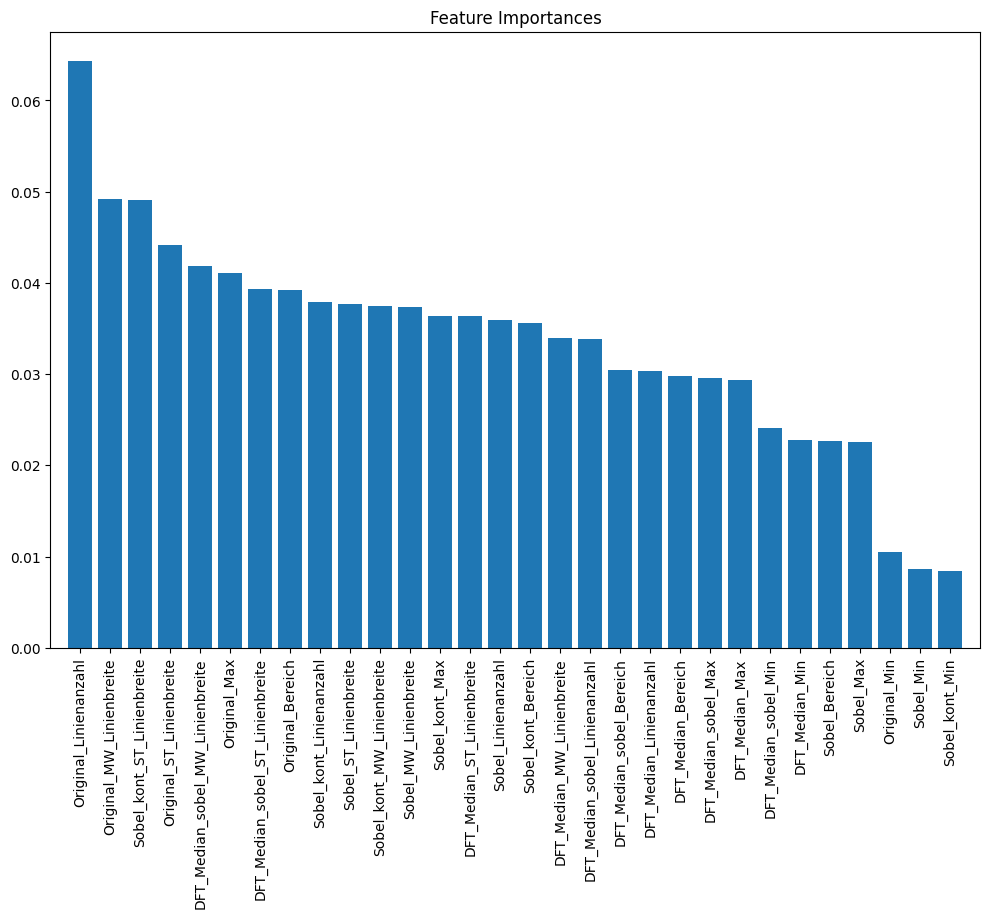

                             Feature  Importance
0              Original_Linienanzahl    0.064314
1           Original_MW_Linienbreite    0.049220
2         Sobel_kont_ST_Linienbreite    0.049071
3           Original_ST_Linienbreite    0.044194
4   DFT_Median_sobel_MW_Linienbreite    0.041862
5                       Original_Max    0.041051
6   DFT_Median_sobel_ST_Linienbreite    0.039291
7                   Original_Bereich    0.039203
8            Sobel_kont_Linienanzahl    0.037937
9              Sobel_ST_Linienbreite    0.037740
10        Sobel_kont_MW_Linienbreite    0.037447
11             Sobel_MW_Linienbreite    0.037370
12                    Sobel_kont_Max    0.036409
13        DFT_Median_ST_Linienbreite    0.036394
14                Sobel_Linienanzahl    0.035909
15                Sobel_kont_Bereich    0.035642
16        DFT_Median_MW_Linienbreite    0.033929
17     DFT_Median_sobel_Linienanzahl    0.033816
18          DFT_Median_sobel_Bereich    0.030426
19           DFT_Med

In [9]:
# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Namen der Features
feature1 = dataset.columns.get_loc('Original_Linienanzahl')
feature2 = dataset.columns.get_loc('DFT_Median_sobel_Bereich')
feature_names = dataset.columns[feature1:feature2+1]

# Visualisierung der Feature Importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Ausgabe der Feature Importances
feature_importances = pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
print(feature_importances)



In [12]:

def select_relevant_features(threshold):
    # Filtern der Features mit Importance < treshold
    important_features = feature_importances[feature_importances['Importance'] >= threshold]

    # Liste der zu behaltenden Features
    features_to_keep = important_features['Feature'].values

    # Auswahl der entsprechenden Spalten aus dem ursprünglichen DataFrame
    X_important = dataset[features_to_keep]
    return X_important


X_important = select_relevant_features(0.02)

array([0.06431389, 0.04922005, 0.0490708 , 0.04419444, 0.04186195,
       0.04105132, 0.03929117, 0.03920293, 0.03793744, 0.03773993,
       0.03744746, 0.03737036, 0.03640903, 0.03639427, 0.0359094 ,
       0.03564217, 0.03392868, 0.03381636, 0.03042552, 0.03038076,
       0.029773  , 0.02960764, 0.02933498, 0.02410819, 0.02282414,
       0.02265957, 0.02257236, 0.01051188, 0.008636  , 0.00836428])

In [ ]:
df1 = dataset.loc[:,'Original_Linienanzahl':'DFT_Median_sobel_Bereich']
df2 = importances[indices]
label_corr = df2.corr()['Good_Quality']
label_corr.sort_values(ascending=False)
train_cols = label_corr[(~label_corr.isna()) &
(np.abs(label_corr) > 0.05)]
train_cols = list(train_cols[:-1].index)
train_cols

In [7]:
# Evaluierung des besten Modells
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
print(f'Normal Model Accuracy: {accuracy}')
print(f'Normal Model Classification Report:\n{report}')
print(f'Best Model Accuracy: {accuracy_best}')
print(f'Best Model Classification Report:\n{report_best}')

Normal Model Accuracy: 0.7655699177438308
Normal Model Classification Report:
              precision    recall  f1-score   support

         bad       0.77      0.71      0.74       798
        good       0.76      0.82      0.79       904

    accuracy                           0.77      1702
   macro avg       0.77      0.76      0.76      1702
weighted avg       0.77      0.77      0.76      1702

Best Model Accuracy: 0.7643948296122209
Best Model Classification Report:
              precision    recall  f1-score   support

         bad       0.77      0.70      0.74       798
        good       0.76      0.82      0.79       904

    accuracy                           0.76      1702
   macro avg       0.77      0.76      0.76      1702
weighted avg       0.77      0.76      0.76      1702

